# Segment and extract traces from 2p Calcium Imaging Micrographs

__Goal:__
_To robustly and automatically segment offline cells avoiding grouping cells together and rarely missing any_

__Finished Tasks:__
* Wrote code to create denoised clean image for segmentation
* Crowd-sourced manual segmentation of ~50 experiments with about 70% of the cells segmented
* Trained Mask-RCNN based on:
__Usiigaci: Instance-aware cell tracking in stain-free phase contrast microscopy enabled by machine learning__
**Hsieh-Fu Tsai<sup>1,2</sup>, Joanna Gajda<sup>3</sup>, Tyler F.W. Sloan<sup>4</sup>, Andrei Rares<sup>5</sup>, and Amy Q. Shen<sup>1</sup>**

<sup><sup>1</sup>Micro/Bio/Nanofluidics Unit, Okinawa Institute of Science and Technology Graduate University, Okinawa Japan</sup>

<sup><sup>2</sup>Research Fellow of Japan Society of Promotion for Science</sup>

<sup><sup>3</sup>AGH University of Science and Technology, Krakow, Poland</sep>

<sup><sup>4</sup>Quorumetrix Solutions, Canada</sup>

<sup><sup>5</sup>ImagineA, The Netherlands</sup>

* Wrote tool to process an experiment from movie to traces

__Unfinished Tasks:__
* Subtract baseline noise from each trace
* Optimize pixels selected from each frame and each segment to maximize SNR
* Still have a bug that re-running the tool without restarting it causes errors
* Replace ImageJ functions with faster and more reliable Python alternatives <br>
_Much of the image processing occurs using imagej functions which are slow and prone to bugs._
* Finish documentation and create repository for easy installation (maybe on Wexac?) 
* Add code to prevent cell label text for overlapping
* Make trace extraction more efficient

# Table of Contents:
* [Import necesssary packages](#chap1)
* [Read experiment directories](#chap2)
* [Define functions for processing stacks](#chap3)
* [Function for calling the trained neural network](#chap4)
* [Decide which experiment to process](#chap5)
* [Align stack and create denoised mean image](#chap6)
* [Run neural network to segment mean image](#chap7)
* [Plot and save overlay image](#chap8)
* [Extract and save traces from all cells in mask](#chap9)
* [Select a cell and plot it's trace](#chap10)

## Import necesssary packages <a class="anchor" id="chap1"></a>

In [2]:
import sys
import shutil
sys.path.insert(0, '/home/mestalbet/Segment2P/')
from segment_functions import *

Using TensorFlow backend.


Imported Packages:

plotly==3.7.1
Pillow==5.4.1
numpy==1.16.2
numba==0.43.1
matplotlib==3.0.3
tqdm==4.31.1
seaborn==0.9.0
scikit-learn==0.20.3
pandas==0.24.1
ipywidgets==7.3.2


## Read experiment directories <a class="anchor" id="chap2"></a>

In [3]:
files = []
stack_dir = "/home/mestalbet/ImageStacks/"
pattern = "*.tif"

for dir, _, _ in os.walk(stack_dir):
    files.extend(glob(os.path.join(dir, pattern)))
    
meanfiles = []
mean_dir = "/home/mestalbet/ImageMeans/"
pattern = "*.png"

for dir, _, _ in os.walk(mean_dir):
    meanfiles.extend(glob(os.path.join(dir, pattern)))

## Run neural network to segment mean image <a class="anchor" id="chap7"></a>

In [4]:
%%capture
# Run Mask RCNN Inference
data_dir = "/home/mestalbet/ImageMeans/"
model_path_1 = "/home/mestalbet/Segment2P/TrainWeights/mask_rcnn_cell_0100.h5"
model_path_2 = "/home/mestalbet/Segment2P/TrainWeights/mask_rcnn_cell_0198.h5"
model_path_3 = "/home/mestalbet/Segment2P/TrainWeights/mask_rcnn_cell_0199.h5"
model_path_4 = "/home/mestalbet/Segment2P/TrainWeights/mask_rcnn_cell_0200.h5"
model_list = [model_path_1, model_path_2, model_path_3, model_path_4]
gc.collect()
mask = segmentimage(data_dir, model_list)
maskdir  = "/home/mestalbet/TempMasks/"
pattern = "_mask_avg/*.png"
maskfiles = []
for dir, _, _ in os.walk(maskdir):
    maskfiles.extend(glob(os.path.join(dir, pattern)))
masks = [skio.imread(mask) for mask in maskfiles]
shutil.rmtree(maskdir)
os.makedirs(maskdir)
for i in range(0,len(masks)):
    skio.imsave(os.path.join(maskdir,maskfiles[i].split('/')[-1]),masks[i]) 
pattern = "png"
maskfiles = []
for dir, _, _ in os.walk(maskdir):
    maskfiles.extend(glob(os.path.join(dir, pattern)))
pattern = "*png"
maskfiles = []
for dir, _, _ in os.walk(maskdir):
    maskfiles.extend(glob(os.path.join(dir,pattern)))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


## Plot and save overlay image <a class="anchor" id="chap8"></a>

In [5]:
tiffs = widgets.Dropdown(
    options=list(set([file.split('/')[-1] for file in files])),
    value=list(set([file.split('/')[-1] for file in files]))[0],
    description='File:',
    disabled=False,
)

def change_fold(*args):
    fold.index = None
    newops = list(set([file.split('/')[6]
                       for file in files if file.split('/')[5] == exp.value]))
    fold.options = sorted(newops)

def change_tiff(*args):
    tiffs.index = None
    newops = list(set([file.split('/')[-1] for file in files]))
    tiffs.options = sorted(newops)

widgets.HBox([tiffs])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, '181028')

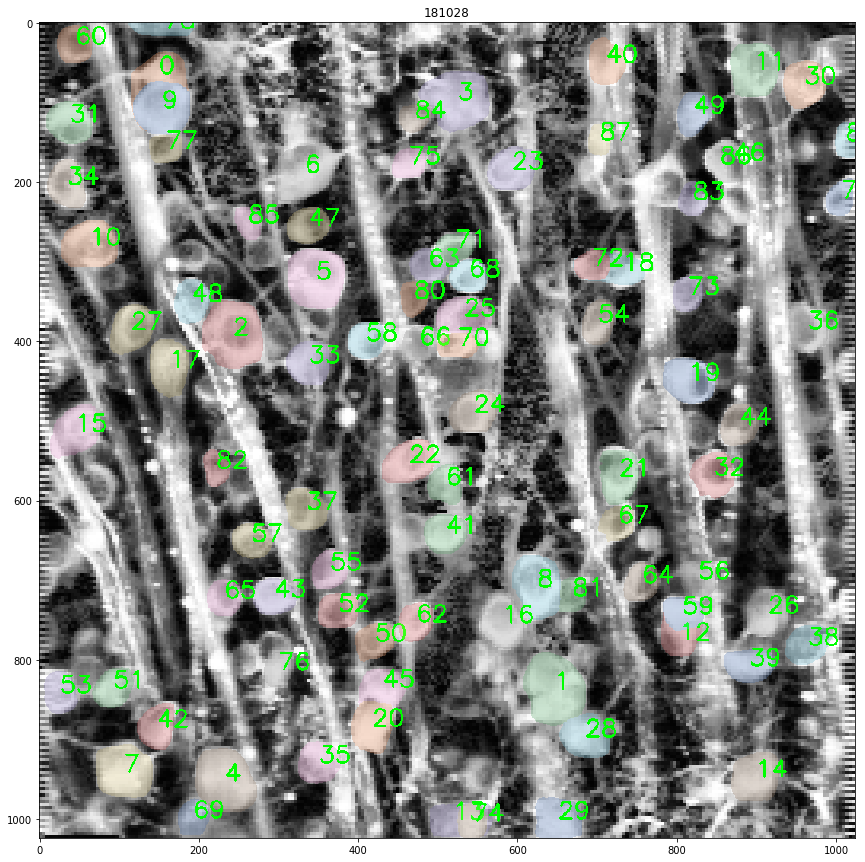

In [6]:
meanimage  = skio.imread([f for f in meanfiles if tiffs.value.split('_')[0] in f][0])
mask  = skio.imread([f for f in maskfiles if tiffs.value.split('_')[0] in f][0])
img = createoverlay(meanimage, mask)
overlayfig = plt.figure(figsize=(15, 15))
ax = overlayfig.add_subplot(111)
ax.imshow(img, interpolation='none')
plt.title(str(tiffs.value.split('_')[0]))

## Extract and save traces from all cells in mask <a class="anchor" id="chap9"></a>

In [ ]:
trace_dir = "/home/mestalbet/TempTraces/"
alignedstack = imread(os.path.join(stack_dir,tiffs.value))
signals = gettraces(alignedstack, mask)
# signals.to_csv(os.path.join(trace_dir, tiffs.value.split('.')[0]+'.csv')) #check data_dir path

## Select a cell and plot it's trace <a class="anchor" id="chap10"></a>

In [ ]:
import plotly.offline as py
py.init_notebook_mode()

In [ ]:
plotly.offline.init_notebook_mode(connected=True)
layout = go.Layout(
    title='Mean pixel value over frame',
    xaxis=dict(
        title='Frame Index',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Average Pixel Intensity',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)

fig = go.FigureWidget(layout=layout)
scatt = fig.add_scatter()


In [ ]:
@interact(a=np.unique(mask)-1)
def update(a=1):
    py.iplot(fig)
    with fig.batch_update():
        scatt.name = "cell "+str(a)
        scatt.x = np.arange(len(signals["traces"].iloc[0]))
        scatt.y = signals["traces"].iloc[a]
        scatt.line.color = "blue"